## Graph Creation

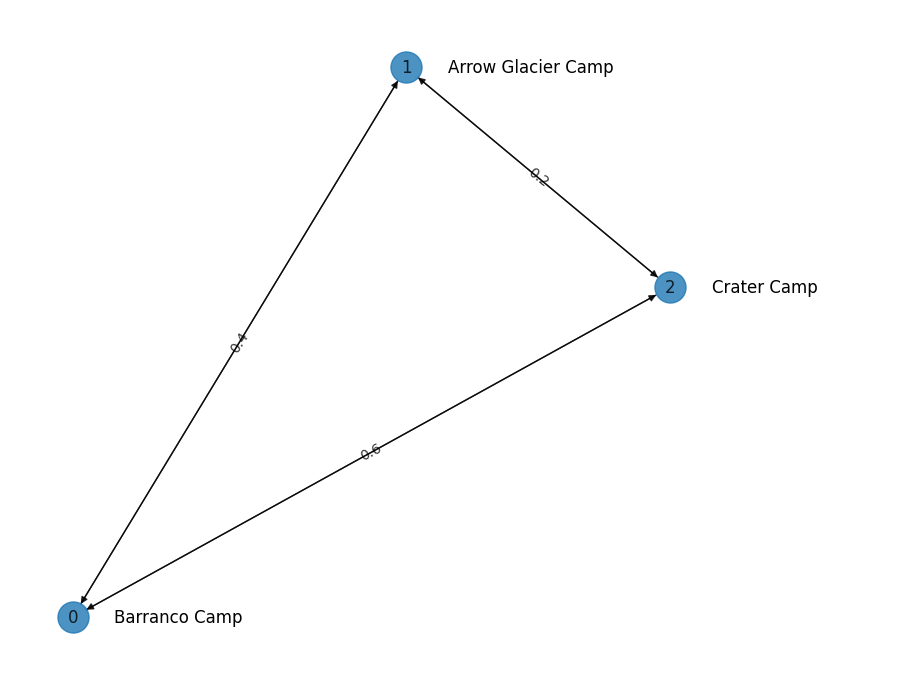

In [2]:
import matplotlib.pylab as plt
import networkx as nx
import numpy as np 

# define a directed graph 
G = nx.DiGraph()

# define the edges of the graph with their corresponding weights
G.add_edge(0, 1, weight=0.4)
G.add_edge(1, 0, weight=0.4)

G.add_edge(0, 2, weight=0.6)
G.add_edge(2, 0, weight=0.6)

G.add_edge(1, 2, weight=0.2)
G.add_edge(2, 1, weight=0.2)


# save the labels of the various edges to be able to plot them.
edge_labels= {}
for (u,v) in G.edges():
    edge_labels[(u,v)] = G[u][v]["weight"]

pos = {0: np.array([-0.3, -0.3 ]), 1: np.array([-0.06 ,  0.2]), 2: np.array([0.13, 0. ])}

# creating node labels
labels = {}
labels[0] = 'Barranco Camp'
labels[1] = 'Arrow Glacier Camp'
labels[2] = 'Crater Camp'

# applying a shift to the node labels for readability purposes 
shift = np.array([0.03, 0])
shifted_pos ={node: node_pos + shift for (node, node_pos) in pos.items()}

# draw node labels
nx.draw_networkx_labels(G, shifted_pos, labels=labels, horizontalalignment="left")


#plot the graph and the edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, alpha=0.8)
nx.draw(G, pos, with_labels=True, alpha=0.8, node_size=500)

# adjust frame to avoid cutting text, may need to adjust the value
axis = plt.gca()
lim = axis.get_xlim()
axis.set_xlim([lim[0], lim[1] * 1.7])

# increase the size of the figure
figure_size = plt.gcf().get_size_inches()
factor = 1.8
plt.gcf().set_size_inches(factor * figure_size)

plt.show()

In [3]:
g_mat = np.zeros((len(G.nodes), len(G.nodes)))
for (i, j) in G.edges:
    g_mat[i, j] = G[i][j]["weight"]
print (g_mat)

[[0.  0.4 0.6]
 [0.4 0.  0.2]
 [0.6 0.2 0. ]]


## Cost Function

In [4]:
from qibo.symbols import Z, X, Y
from qibo import hamiltonians



def cost_function(G: nx.Graph, x):
    cost = [0.8, 3.2, 0.6]
    sham = 0
    P = 5
    for i in range(len(cost)):
        sham += (cost[i] * (1 - Z(i)) / 2) + P * (2 - ((1 - Z(i)) / 2)) *  (2 - ((1 - Z(i)) / 2))

    return hamiltonians.SymbolicHamiltonian(sham)
    



In [5]:
from qibo.symbols import Z, X, Y
from qibo import hamiltonians


def build_TSP_hamiltonian(G : nx.Graph) ->  hamiltonians.SymbolicHamiltonian:
    
    cost = [1.2, 3.2, 0.6]
    sham = 0
    P = 20
    shamp = 0
    for i in range(len(cost)):
        sham += (cost[i] * (1 - Z(i)) / 2)
    for j in range(len(cost)):
        shamp += (1 - Z(j)) / 2
    
    sham = sham + P * (2 - shamp) * (2 - shamp)

    return hamiltonians.SymbolicHamiltonian(sham)
    

def build_mixer_hamiltonian(G: nx.Graph) ->  hamiltonians.SymbolicHamiltonian:
    sham = sum((X(i)) for i in range(len(G.nodes)))
    
    return hamiltonians.SymbolicHamiltonian(sham)

def build_initial_hamiltonian(G: nx.Graph) ->  hamiltonians.SymbolicHamiltonian:
    sham = sum((X(i)) for i in range(len(G.nodes)))
    
    return hamiltonians.SymbolicHamiltonian(sham)

def prepare_initial_state(G: nx.Graph):
    return np.ones(8) 

def display_solution(state: str):
    print(state)

## Solution Finding


In [6]:

hamiltonian = build_TSP_hamiltonian(G)

dense = hamiltonian.dense.matrix

print(dense) 
len(dense)

[Qibo 0.1.13|INFO|2023-05-07 00:22:51]: Using numpy backend on /CPU:0
[Qibo 0.1.13|WARNING|2023-05-07 00:22:51]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


[[80. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j 20.6+0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j 23.2+0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  3.8+0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j 21.2+0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  1.8+0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  4.4+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j 25. +0.j]]


8

In [7]:
import numpy as np
from qibo import models, hamiltonians


nqubits = 3
print("number of qubits needed to solve the problem: ", nqubits)

# create the cost Hamiltonian for the given graph
hamiltonian = build_TSP_hamiltonian(G)

# create the mixer Hamiltonian for the given graph
mixer_hamiltonian = build_mixer_hamiltonian(G)

# create QAOA model given the Hamiltonians
qaoa = models.QAOA(hamiltonian=hamiltonian, mixer=mixer_hamiltonian)

# optimize using random initial variational parameters with eight layers 
# Note: you can change the number of layers but it has to be an even number
num_layers = 8
initial_parameters = np.random.random(num_layers) 

# prepare the initial state of the QAOA optimization 
initial_state = prepare_initial_state(G) 

# run the QAOA optimization with the initial parameters and the hamiltonians defined
best_energy, final_parameters, extra = qaoa.minimize(
    initial_parameters, 
    method="BFGS",
    initial_state=initial_state
    )

print("best energy: ", best_energy)

number of qubits needed to solve the problem:  3
best energy:  17.929768911640025


In [8]:
from qibo.states import CircuitResult
from qibo import gates
from qibo.models import Circuit

# build the circuit using the optimal parameters optimized by QAOA
qaoa.set_parameters(final_parameters)
quantum_state = qaoa.execute(initial_state)

# measure the output of the circuit and obtain results
nshots= 4000
circuit = Circuit(nqubits)
circuit.add(gates.M(*range(nqubits)))
result = CircuitResult(qaoa.backend, circuit, quantum_state, nshots=nshots)
freq_counter = result.frequencies()

# order the results according to the frequencies
ordered_freq_counter = sorted(freq_counter.items(), key=lambda item: item[1], reverse=True)
qaoa_solution = ordered_freq_counter[0][0]

display_solution(qaoa_solution) # QAOA solution is a binary string containing the solution 

101


## Adiabatic

In [9]:
import numpy as np
from qibo.models.evolution import AdiabaticEvolution
from qibo.hamiltonians.hamiltonians import Hamiltonian

# build initial (H0) and target (H1) hamiltonians
H1 = build_TSP_hamiltonian(G)
H0 = build_initial_hamiltonian(G)

dt = 0.1
nqubits = 3

# calculate the dense hamiltonian from the symbolic hamiltonian
H1_dense = Hamiltonian(nqubits, H1.matrix)
H0_dense = Hamiltonian(nqubits, H0.matrix)

# define the scheduler
def s(t): return t



# construct the adiabatic model
adiabatic_model = AdiabaticEvolution(H0_dense, H1_dense, s, dt)

[Qibo 0.1.13|WARNING|2023-05-07 00:23:01]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.1.13|WARNING|2023-05-07 00:23:01]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


In [10]:
# execute the adiabatic optimization
adiabatic_quantum_state = adiabatic_model.execute(final_time=100) 

# obtain the state with the highest probability
solution_dec = (np.abs(adiabatic_quantum_state) ** 2).argmax()

adiabatic_solution = "{0:0{bits}b}".format(solution_dec, bits=nqubits)

display_solution(adiabatic_solution) # adiabatic solution is a binary string containing the solution

101
